# Exercise
You can use code and models which are publicly available. Please provide: short description what
you did, how it is done, what is the result. Please be prepared to present the solution in the exercises
(best in form of a Jupyter notebook .ipynb).

(a) (6 Pts.) 

Take a model for the FashionMNIST or MNIST data set. Take 2 different examples
from two different classes. Use at least three local explanation methods (you implemented
yourself) and explain reasons they are mapped to the true, the most likely, second most likely,
and least likely class. Interpret the results. Are the explanations meaningful? Do they differ for
different target outputs? What happens if the examples are adversarially attacked (with a local
change of only small parts of the image)? Also try this out experimentally.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random

In [2]:
# Transformations for the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

In [3]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(-1, 64 * 5 * 5)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

# Instantiate and train the model
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
for epoch in range(1, 6):  # 5 epochs
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print(f'Accuracy: {correct / len(test_loader.dataset):.4f}')

Epoch 1, Loss: 0.2803021967411041
Epoch 2, Loss: 0.18500803411006927
Epoch 3, Loss: 0.3022685647010803
Epoch 4, Loss: 0.25710541009902954
Epoch 5, Loss: 0.31104934215545654
Accuracy: 0.9126


### Saliency Maps

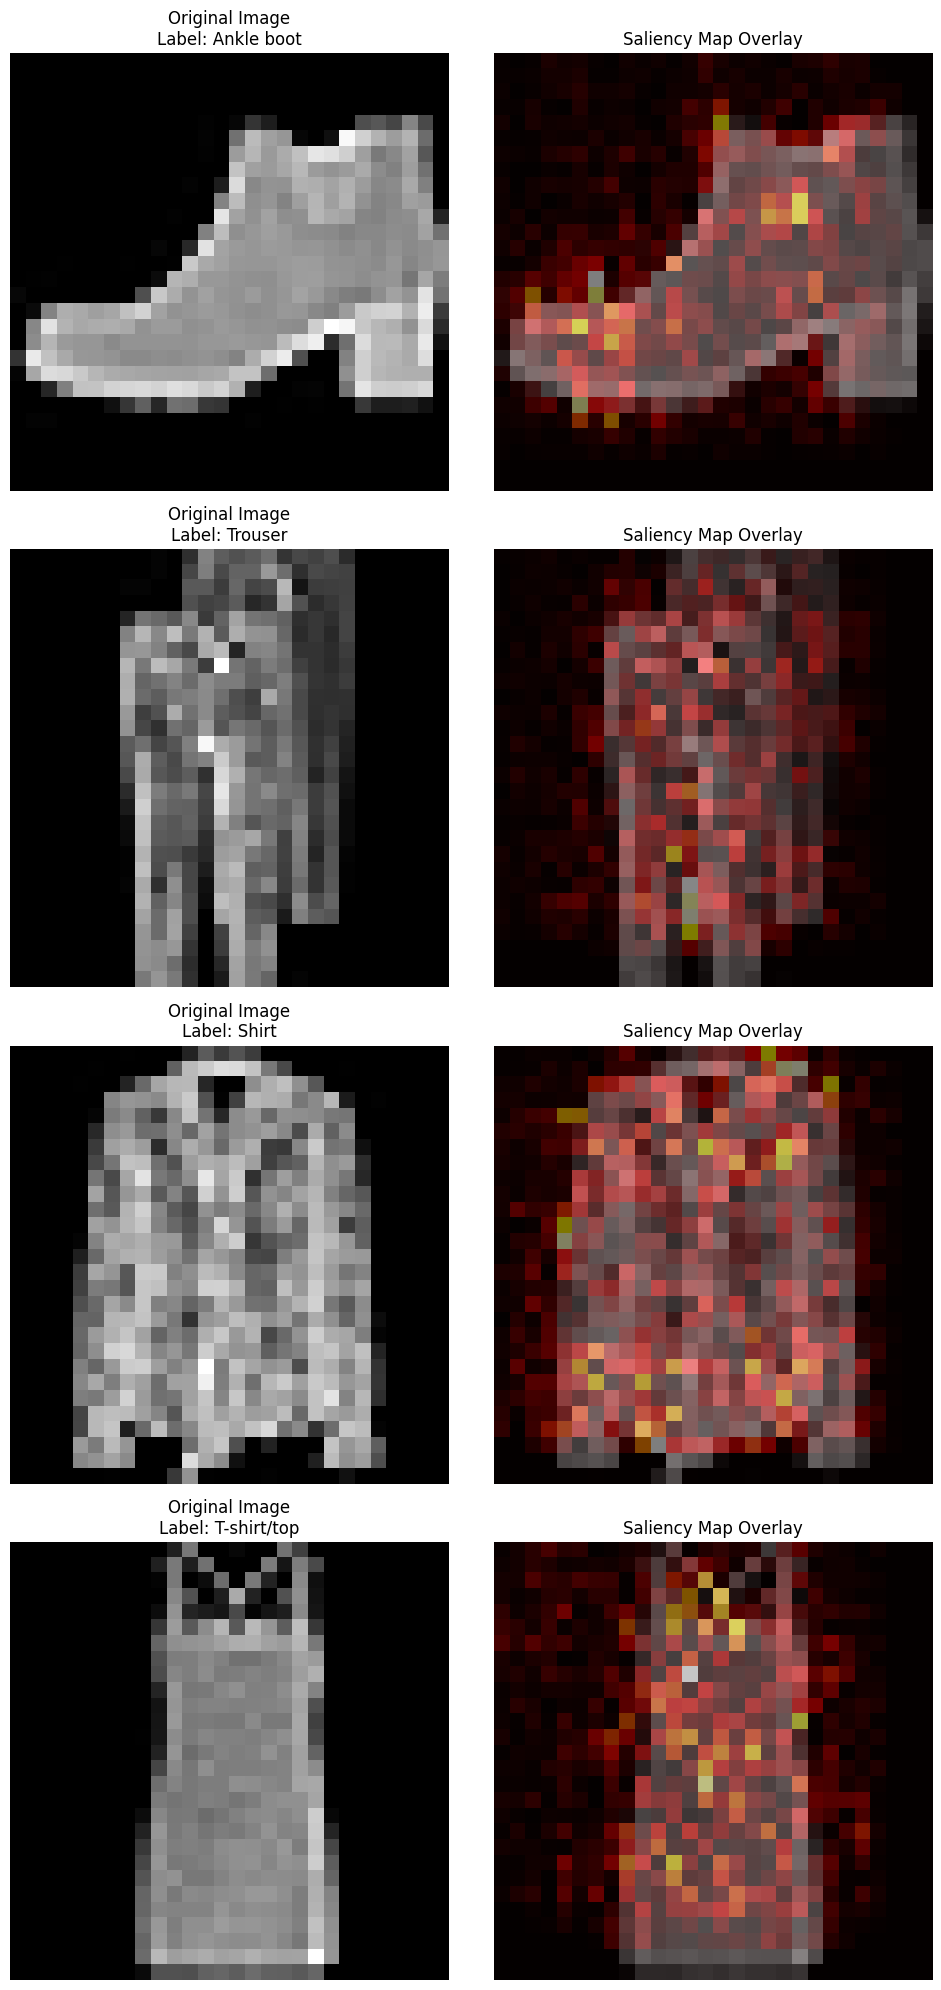

In [6]:
def saliency_map(model, image, label):
    image = image.unsqueeze(0)
    image.requires_grad_()
    output = model(image)
    model.zero_grad()
    output[0, label].backward()
    saliency = image.grad.data.abs().squeeze().numpy()
    return saliency


def plot_examples_with_saliency(images, saliency_maps, labels, class_names):
    fig, axs = plt.subplots(len(images), 2, figsize=(10, len(images) * 5))
    
    if len(images) == 1:  # if there is only one image, axs is not a 2D array
        axs = [axs]

    for i, (img, saliency, lbl) in enumerate(zip(images, saliency_maps, labels)):
        class_name = class_names[lbl]
        
        # Original image
        axs[i][0].imshow(img.squeeze(), cmap='gray')
        axs[i][0].set_title(f'Original Image\nLabel: {class_name}')
        axs[i][0].axis('off')

        # Overlay saliency map on the original image
        axs[i][1].imshow(img.squeeze(), cmap='gray')
        axs[i][1].imshow(saliency, cmap='hot', alpha=0.5)  # Overlay with transparency
        axs[i][1].set_title('Saliency Map Overlay')
        axs[i][1].axis('off')

    plt.tight_layout()
    plt.show()

def get_random_examples(dataset, num_examples=4):
    selected_examples = []
    selected_labels = []
    seen_labels = set()
    
    while len(selected_examples) < num_examples:
        idx = random.randint(0, len(dataset) - 1)
        img, lbl = dataset[idx]
        if lbl not in seen_labels:
            selected_examples.append(img)
            selected_labels.append(lbl)
            seen_labels.add(lbl)
            
    return selected_examples, selected_labels

# Get 4 different examples from the test dataset
examples, labels = get_random_examples(test_dataset, num_examples=4)

# Compute saliency maps for the examples
saliency_maps = [saliency_map(model, img, lbl) for img, lbl in zip(examples, labels)]

# Plot the examples with saliency maps
plot_examples_with_saliency(examples, saliency_maps, labels, class_names)

### Grad-CAM

In [5]:
from torchvision.models import resnet18
from torch.nn import functional as F

def grad_cam(model, image, label):
    image = image.unsqueeze(0)
    features = []
    gradients = []

    def save_feature_hook(module, input, output):
        features.append(output)

    def save_gradient_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    model.conv2.register_forward_hook(save_feature_hook)
    model.conv2.register_backward_hook(save_gradient_hook)

    output = model(image)
    model.zero_grad()
    output[0, label].backward()

    gradient = gradients[0].mean(dim=(2, 3), keepdim=True)
    cam = F.relu((gradient * features[0]).sum(dim=1)).squeeze().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize to [0, 1]
    return cam

# Get Grad-CAM for the examples
grad_cams = [grad_cam(model, img, lbl) for img, lbl in zip(examples, labels)]

# Plot Grad-CAM
plot_examples(grad_cams, labels)

c:\Users\felix\miniconda3\envs\deeplearning\Lib\site-packages\torch\nn\modules\module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


NameError: name 'plot_examples' is not defined

### LIME